In [1]:
import boto3 #Amazon AWS Python SDK
from botocore.config import Config #Config for SDK
from dotenv import load_dotenv # Load .ENV file containing protected information
import os # Ability to manage and access neigboring files 
from io import BytesIO # For reading binary data from S3
import pandas as pd # For data manipulation
from tqdm import tqdm # For progress bars
import matplotlib.pyplot as plt # For plotting data

In [2]:
# Make the environment variables available to python from the .env file
load_dotenv()
# Load the environment variables into python variables
ACCESS_KEY = os.getenv("AWS_ACCESS_KEY_ID")
SECRET_KEY = os.getenv("AWS_SECRET_ACCESS_KEY")
POLYGON_KEY = os.getenv("POLYGON_API_KEY")

In [4]:
# Initialize a session using the AWS keys
session = boto3.Session( # Session object used to configure users and environment control
    aws_access_key_id=ACCESS_KEY,
    aws_secret_access_key=SECRET_KEY,
)

In [5]:
# Create a client with session and speficy the endpoint (where the data is located)
s3 = session.client(
    's3', # Connecting to the S3 (Simple Storage Service) specifically (can connect to any aws service here)
    endpoint_url='https://files.polygon.io', # Base url for the service you want to access
    config=Config(signature_version='s3v4'), # Ensures client is using AWS signature Version 4 protocol by prohibiting api requests unless supplied with
                                             # a secret key. Used for hashsing
)
# The previous code is everything needed to accesss the S3 flatfiles

In [6]:
# Initialize a paginator for listing objects
paginator = s3.get_paginator('list_objects_v2')

In [7]:
# Choose the appropriate prefix depending on the data you need:
# - 'global_crypto' for global cryptocurrency data
# - 'global_forex' for global forex data
# - 'us_indices' for US indices data
# - 'us_options_opra' for US options (OPRA) data
# - 'us_stocks_sip' for US stocks (SIP) data
def get_daily_polygon_files(start_year, years):
    """
    returns all the s3 files to download

    Args:
        start_year (int): Year to start historical data pull.
        years (int): Amount of years to pull files for.

    Returns:
        object_keys: A list of files that will be pulled from S3.
    """
    #One liner to make the list of years to pull from. Paginator will recursively get all the files from s3
    prefixes = [f'us_stocks_sip/day_aggs_v1/{year}' for year in range(start_year, start_year + years)]
    # List objects using the selected prefix
    object_keys = []
    for prefix in prefixes: #Step into each parent fdirectory
        for page in paginator.paginate(Bucket='flatfiles', Prefix=prefix): #Use the paginator to search throuigh the files in the remote S3 bucket
            for obj in page['Contents']: # Step into each month folder
                object_keys.append(obj['Key']) #Append the name of each daily file to a list
    return object_keys

In [8]:
def get_daily_data(keys):
    """
    grabs all the csv files stored in keys, unzips them, and concatenates them all in a dataframe


    Args:
        keys (String[]): list of csv file paths to download from s3

    Returns:
        Dataframe: dataframe with stock data appended from all days
    """
    dfs = []
    for key in tqdm(keys, desc="Fetching Stock data"): #Progress bar loop for each file
        if key.endswith('csv.gz'): #Only download the compressed csv files
            response = s3.get_object(Bucket='flatfiles', Key=key) # Download the object from S3
            df = pd.read_csv(BytesIO(response['Body'].read()), compression = 'gzip') # Read the raw compressed file as bytes and store them in our computers main memory(RAM)
            dfs.append(df) # Read the bytes into a pandas DataFrame, specifying that the file is compressed with gzip
    return pd.concat(dfs, ignore_index=True)   # Concatenate all the dataframes in the list into a single dataframe           

In [9]:
data = get_daily_data(get_daily_polygon_files(2021, 5))

Fetching Stock data: 100%|████████████████████████████████████████████████████████████████████████| 1078/1078 [01:41<00:00, 10.66it/s]


In [10]:
def data_evaluation(data):
    """
    evaluates the data and prints null values and missing data

    Args:
        data: input data frame

    Returns:
        Void
    """
    ticker_counts = data['ticker'].value_counts()
    most_common_value = ticker_counts.mode().iloc[0]
    num_incomplete_tickers = int((ticker_counts != most_common_value).sum())
    incomplete_percentage = (num_incomplete_tickers / ticker_counts.size) * 100
    **
    print(f"""
Amount of null values per column: \n {data.isnull().sum()} \n
Number of unique tickers: {data['ticker'].nunique()}
The mode of the amount of tickers is {most_common_value}
The number of incomplete tickers is {num_incomplete_tickers}
The percentage of incomplete tickers relative to the mode is {incomplete_percentage:.3f}%
    """)

In [11]:
data_evaluation(data)


Amount of null values per column: 
 ticker          693
volume            0
open              0
close             0
high              0
low               0
window_start      0
transactions      0
dtype: int64 

Number of unique tickers: 18017
The mode of the amount of tickers is 1078
The number of incomplete tickers is 12477
The percentage of incomplete tickers relative to the mode is 69.251%
    


In [13]:
def get_clean_tickers(data):
   """ 
   filters out incomplete tickers from the data
   
   Args:
       data: input data frame
       
   Returns:
       dataframe: filtered dataframe with only complete tickers
   """
   #Remove null tickers from ticker list
   unique_tickers = data['ticker'].dropna().unique() #Get unique tickers, dropping nulls
   tickers_with_null = data[data.isnull().any(axis=1)]['ticker'].dropna().unique().tolist() #Get tickers with null values
   valid_tickers = list(set(unique_tickers) - set(tickers_with_null)) #Get valid tickers by removing null tickers from unique tickers

   #Create new filtered DataFrame and filter further based on mode amount of samples
   filtered_null_data = data[data['ticker'].isin(valid_tickers)] #Filter out null tickers from data
   ticker_counts = filtered_null_data['ticker'].value_counts() #Count the number of rows for each ticker
   most_common_value = ticker_counts.mode().iloc[0] #Get the mode of the number of rows for each ticker
   # Get tickers that don't have the mode number of rows
   incomplete_tickers = ticker_counts[ticker_counts != most_common_value].index.tolist() #Get tickers that don't have the mode number of rows
   filtered_final_data = filtered_null_data[filtered_null_data['ticker'].isin(list(set(valid_tickers) - set(incomplete_tickers)))] #Filter out incomplete tickers from data

   #Print null tickers, evaulate final data, and return final df
   print(f"tickers with null: {tickers_with_null}")
   data_evaluation(filtered_final_data) #Evaluate the final data to ensure it is valid
   filtered_final_data = filtered_final_data.copy() #Avoid SettingWithCopyWarning
   filtered_final_data['time'] = pd.to_datetime(filtered_final_data['window_start']).dt.date #Convert nanosecond time to datetime format
   filtered_final_data = filtered_final_data.drop(columns=['window_start']) #Drop the window_start column
   return filtered_final_data

In [14]:
filtered_data = get_clean_tickers(data)

tickers with null: []

Amount of null values per column: 
 ticker          0
volume          0
open            0
close           0
high            0
low             0
window_start    0
transactions    0
dtype: int64 

Number of unique tickers: 5540
The mode of the amount of tickers is 1078
The number of incomplete tickers is 0
The percentage of incomplete tickers relative to the mode is 0.000%
    


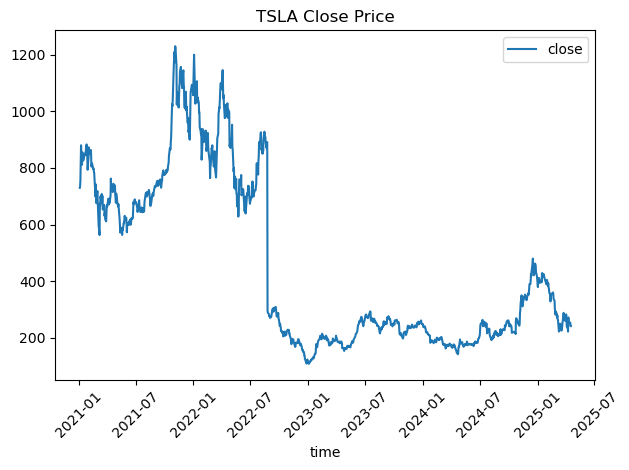

In [15]:
filtered_data[filtered_data['ticker'] == 'TSLA'].plot(x='time', y='close', title='TSLA Close Price')
plt.xticks(rotation=45)  # Rotate x-axis labels vertically
plt.tight_layout()       # Optional: prevent clipping
plt.show()

In [17]:
from polygon import RESTClient

client = RESTClient(POLYGON_KEY) # Initialize the Polygon.io REST client with API key

splits = []
for s in tqdm(client.list_splits(
   order="asc", # Order by ascending execution date
   limit="10", # Limit to 10 results per request (max is 1000)
   sort="execution_date", # Sort by execution date
   )):
   splits.append(s)  # Append each split to the list

25861it [03:01, 142.79it/s]


In [18]:
data

,ticker,volume,open,close,high,low,window_start,transactions
0,A,1980148,118.940,118.6400,120.09,117.1100,1609736400000000000,21357
1,AA,5400045,23.620,23.2500,24.45,23.1250,1609736400000000000,30118
2,AAA,3722,25.065,25.0654,25.07,25.0650,1609736400000000000,20
3,AAAU,767803,19.330,19.3500,19.36,19.2243,1609736400000000000,1190
4,AACG,17972,1.170,1.1800,1.22,1.1700,1609736400000000000,111
...,...,...,...,...,...,...,...,...
11542217,ZXZZT,15448,12.100,12.1900,12.19,12.1000,1744862400000000000,259
11542218,ZYBT,890867,7.930,10.0600,10.47,7.2300,1744862400000000000,4715
11542219,ZYME,383335,11.230,11.5300,11.59,11.1200,1744862400000000000,5408
11542220,ZYXI,113137,2.140,2.1800,2.20,2.1100,1744862400000000000,1413


In [19]:
def adjust_for_splits(data, splits):
   """
   Adjusts the OHLCV data for stock splits.
   
   Args:
       data (DataFrame): DataFrame containing OHLCV data with columns ['time', 'ticker', 'open', 'high', 'low', 'close', 'volume'].
       splits (list): List of split objects containing attributes 'execution_date', 'split_from', 'split_to', and 'ticker'.
       
   Returns:
       DataFrame: Adjusted OHLCV data.
   """
   
   start_date = pd.to_datetime(data['time'].min()) # Get the start and end date of the data
   end_date = pd.to_datetime(data['time'].max()) 

   tickers_in_data = set(data['ticker'].unique()) # Create a set of valid tickers in the data

   # Filter splits to only include those within the date range and valid tickers
   filtered = [
       s for s in splits # List comprehension to filter splits
       if start_date <= pd.to_datetime(s.execution_date) <= end_date # Only include splits within the date range
       and s.ticker in tickers_in_data # Only include splits for tickers in the data
   ]

   data = data.copy() # Avoid SettingWithCopyWarning
   splits = sorted(filtered, key=lambda s: s.execution_date) # Sort splits by execution date

   for split in tqdm(splits, desc='Adjusting ohlcv data to splits'): # Progress bar loop for each split
       exec_date = pd.to_datetime(split.execution_date) # Convert execution date to datetime
       ratio = split.split_from / split.split_to # Calculate the split ratio
       ticker = split.ticker # Get the ticker symbol

       # Use the 'time' column for the date filter
       mask = (data['ticker'] == ticker) & (pd.to_datetime(data['time']) < exec_date) # Create a boolean mask for the date range to adjust
       data.loc[mask, ['open', 'high', 'low', 'close']] *= ratio # Adjust the OHLC prices by the split ratio
       data.loc[mask, 'volume'] /= ratio # Adjust the volume by the inverse of the split ratio

   return data

In [20]:
data = adjust_for_splits(filtered_data, splits)

/tmp/ipykernel_23656/2432450480.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[167208.45 134751.3  227146.4  161302.55 117286.15]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[mask, 'volume'] /= ratio
Adjusting ohlcv data to splits: 100%|███████████████████████████████████████████████████████████████| 761/761 [06:13<00:00,  2.04it/s]


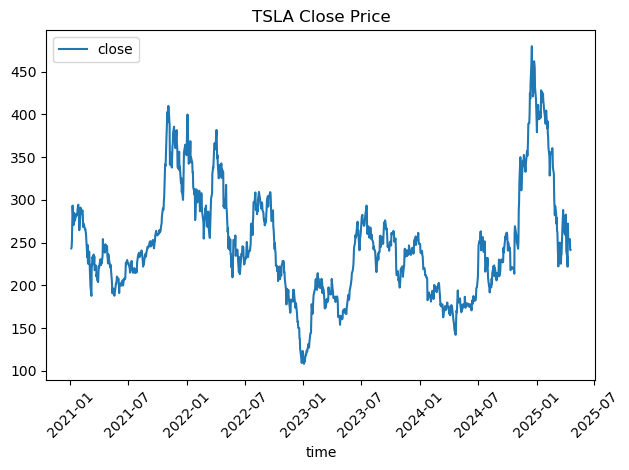

In [21]:
data[data['ticker'] == 'TSLA'].plot(x='time', y='close', title='TSLA Close Price')
plt.xticks(rotation=45)  # Rotate x-axis labels vertically
plt.tight_layout()       # Optional: prevent clipping
plt.show()

In [22]:
data_evaluation(data)


Amount of null values per column: 
 ticker          0
volume          0
open            0
close           0
high            0
low             0
window_start    0
transactions    0
time            0
dtype: int64 

Number of unique tickers: 5540
The mode of the amount of tickers is 1078
The number of incomplete tickers is 0
The percentage of incomplete tickers relative to the mode is 0.000%
    


In [24]:
db_user = os.getenv("POSTGRES_USER")
db_password = os.getenv("POSTGRES_PASSWORD")
db_host = os.getenv("POSTGRES_HOST")
db_port = os.getenv("POSTGRES_PORT")
db_name = os.getenv("POSTGRES_DB")

In [25]:
from sqlalchemy import create_engine

engine = create_engine(
    f"postgresql+psycopg2://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}"
)

In [28]:
# 1) Extract unique tickers from your existing DataFrame
tickers = data['ticker'].dropna().unique().tolist() # Get unique tickers, dropping nulls
print("First 20 tickers:", tickers[:20]) # Print the first 20 tickers for inspection

# 2) Initialize lists to hold metadata and bad tickers
meta_list   = []
bad_tickers = []

# 3) Loop through tickers
for t in tqdm(tickers, desc="Fetching ticker details"): # Progress bar loop for each ticker
   try: 
       resp = client.get_ticker_details(t) # Get ticker details from Polygon.io
   except Exception: 
       # couldn’t fetch details at all 
       bad_tickers.append(t) 
       continue**

   # build a simple dict from resp attributes
   record = {
       'ticker':                     t,
       'active':                     resp.active,
       'market_cap':                 resp.market_cap,
       'list_date':                  resp.list_date,
       'sic_code':                   resp.sic_code,
   }

   # 4) if inactive or any field (besides ticker) is None → mark bad & skip
   has_missing = any(
       record[field] is None # check for None values
       for field in record 
       if field != 'ticker'
   )
   if not record['active'] or has_missing: # Check if ticker is inactive or has missing fields
       bad_tickers.append(t) 
       continue

   # 5) otherwise keep it
   meta_list.append(record) 

# 6) Build the clean DataFrame
meta_df = pd.DataFrame(meta_list) # Create DataFrame from metadata list

# 7) Deduplicate bad_tickers 
bad_tickers = sorted(set(bad_tickers)) # Remove duplicates and sort

# 8) Inspect
print("Clean metadata:")
print(meta_df.head())
print(f"\nTickers skipped (inactive or missing data): {len(bad_tickers)}")

First 20 tickers: ['A', 'AA', 'AAA', 'AAAU', 'AAL', 'AAOI', 'AAON', 'AAP', 'AAPL', 'AAT', 'AAXJ', 'AB', 'ABBV', 'ABCB', 'ABCL', 'ABEO', 'ABEQ', 'ABEV', 'ABG', 'ABM']


Fetching ticker details: 100%|████████████████████████████████████████████████████████████████████| 5540/5540 [04:38<00:00, 19.91it/s]

Clean metadata:
  ticker  active    market_cap   list_date sic_code
0      A    True  2.998995e+10  1999-11-18     3826
1     AA    True  6.474725e+09  2016-10-18     3334
2    AAL    True  6.206615e+09  2013-12-10     4512
3   AAOI    True  5.653103e+08  2013-09-26     3674
4   AAON    True  6.705448e+09  1990-12-01     3585

Tickers skipped (inactive or missing data): 2970
['AAA', 'AAAU', 'AAXJ', 'ABEQ', 'ABEV', 'ACB', 'ACES', 'ACGLO', 'ACIO', 'ACIU', 'ACP', 'ACSI', 'ACTV', 'ACV', 'ACVF', 'ACWI', 'ACWV', 'ACWX', 'ADFI', 'ADME', 'ADX', 'AEF', 'AEFC', 'AEG', 'AEM', 'AER', 'AESR', 'AFB', 'AFGC', 'AFIF', 'AFK', 'AFLG', 'AFMC', 'AFMD', 'AFSM', 'AFYA', 'AG', 'AGD', 'AGG', 'AGGY', 'AGI', 'AGNCM', 'AGNCN', 'AGNCO', 'AGNCP', 'AGQ', 'AGRO', 'AGZ', 'AGZD', 'AHLpD', 'AHLpE', 'AIA', 'AIEQ', 'AIO', 'AIQ', 'AIRR', 'AIZN', 'AKO.B', 'ALC', 'ALLT', 'ALLpB', 'ALLpH', 'ALLpI', 'ALTL', 'ALTY', 'AMLP', 'AMOM', 'AMUB', 'AMX', 'AMZA', 'ANEW', 'ANGL', 'AOA', 'AOD', 'AOK', 'AOM', 'AOR', 'API', 'AQN', 'AQNB', 

In [29]:
len(bad_tickers)

2970

In [30]:
len(tickers)

5540

In [32]:
# Filter out bad tickers from the data
new_tickers = [t for t in tickers if t not in bad_tickers]
filtered_data = data[data['ticker'].isin(new_tickers)].copy()

# Reset the index
filtered_data.reset_index(drop=True, inplace=True)

#evaluate the new data 
data_evaluation(filtered_data)

In [33]:
data_evaluation(filtered_data)


Amount of null values per column: 
 ticker          0
volume          0
open            0
close           0
high            0
low             0
transactions    0
time            0
dtype: int64 

Number of unique tickers: 2570
The mode of the amount of tickers is 1078
The number of incomplete tickers is 0
The percentage of incomplete tickers relative to the mode is 0.000%
    


In [34]:
meta_df

,ticker,active,market_cap,list_date,sic_code
0,A,True,2.998995e+10,1999-11-18,3826
1,AA,True,6.474725e+09,2016-10-18,3334
2,AAL,True,6.206615e+09,2013-12-10,4512
3,AAOI,True,5.653103e+08,2013-09-26,3674
4,AAON,True,6.705448e+09,1990-12-01,3585
...,...,...,...,...,...
2565,ZS,True,3.085833e+10,2018-03-16,7371
2566,ZTS,True,6.727937e+10,2013-02-01,2834
2567,ZUMZ,True,2.474984e+08,2005-05-06,5600
2568,ZYME,True,7.653457e+08,2017-04-28,2834


In [35]:
# append your ticker metadata into the existing ticker_metadata table
meta_df.to_sql(
    "ticker_metadata",
    engine,
    if_exists="append",
    index=False
)


570

In [38]:
# append your OHLCV DataFrame into the existing ohlcv_data table
filtered_data.to_sql(
    "ohlcv_data",
    engine,
    if_exists="append",
    index=False
)


460